In [ ]:
import vectorbtpro as vbt
vbt.settings.set_theme("dark")

SYMBOL = "BTC-USD"
TIMEFRAME = "1 hour"
START = "one year ago"

LAST_N_BARS = 66
PRED_N_BARS = 12

GIF_FNAME = "projections.gif"
GIF_N_BARS = 72
GIF_FPS = 4
GIF_PAD = 0.01

data = vbt.YFData.pull(SYMBOL, timeframe=TIMEFRAME, start=START)

def find_patterns(data):
    price = data.hlc3
    pattern = price.values[-LAST_N_BARS:]
    pattern_ranges = price.vbt.find_pattern(
        pattern=pattern,
        rescale_mode="rebase",
        overlap_mode="allow",
        wrapper_kwargs=dict(freq=TIMEFRAME)
    )
    pattern_ranges = pattern_ranges.status_closed
    return pattern_ranges

pattern_ranges = find_patterns(data)

def plot_projections(data, pattern_ranges, **kwargs):
    projection_ranges = pattern_ranges.with_delta(
        PRED_N_BARS,
        open=data.open,
        high=data.high,
        low=data.low,
        close=data.close,
    )
    projection_ranges = projection_ranges.status_closed
    return projection_ranges.plot_projections(
        plot_past_period=LAST_N_BARS,
        **kwargs,
    )

plot_projections(data, pattern_ranges, plot_bands=True).show_png()


In [16]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Define constants
SYMBOL = "BTC-USD"
TIMEFRAME = "1h"  # Use lowercase for yfinance
START = "1y"

LAST_N_BARS = 66
PRED_N_BARS = 12

# Download data from Yahoo Finance
# data = yf.download(SYMBOL, period=START, interval=TIMEFRAME)

# # Check if data is empty
# if data.empty:
#     raise ValueError(f"No data received for {SYMBOL} with interval {TIMEFRAME}. Check if the symbol or interval is valid.")
#
# # Ensure data is sorted by date
# data.sort_index(inplace=True)



def three_white_soldiers(open, high, low, close):
    """
    Detects the Three White Soldiers candlestick pattern.

    Args:
        open (np.array): Open prices.
        high (np.array): High prices.
        low (np.array): Low prices.
        close (np.array): Close prices.

    Returns:
        np.array: Boolean array indicating where the pattern occurs.
    """
    pattern = np.zeros(len(close), dtype=bool)
    for i in range(2, len(close)):  # Need at least 3 candles
        # Condition 1: Three consecutive bullish candles
        c1 = close[i] > open[i]
        c2 = close[i - 1] > open[i - 1]
        c3 = close[i - 2] > open[i - 2]

        # Condition 2: Each candle closes higher than the previous close
        c4 = close[i] > close[i - 1]
        c5 = close[i - 1] > close[i - 2]

        # Condition 3: Each candle opens within the previous candle's *body*
        c6 = open[i] > open[i - 1]
        c7 = open[i] < close[i - 1]
        c8 = open[i - 1] > open[i-2]
        c9 = open[i - 1] < close[i-2]

        if c1 and c2 and c3 and c4 and c5 and c6 and c7 and c8 and c9:
            pattern[i] = True
    return pattern


def find_patterns(data):
    pattern_ranges = []
    high = data["High"].values
    low = data["Low"].values
    open_price = data["Open"].values
    close = data["Close"].values
    data_len = len(close) # store the length of the data

    for i in range(data_len - LAST_N_BARS -1): # iterate up to the last possible range
        sub_high = high[i:i + LAST_N_BARS]
        sub_low = low[i:i + LAST_N_BARS]
        sub_open = open_price[i:i + LAST_N_BARS]
        sub_close = close[i:i + LAST_N_BARS]

        if len(set(sub_close)) > 1:
            three_white_soldiers_result = three_white_soldiers(sub_open, sub_high, sub_low, sub_close)
            if three_white_soldiers_result[-1]:
                pattern_ranges.append((i, i + LAST_N_BARS - 1))
    return pattern_ranges

# pattern_ranges = find_patterns(data)

def plot_projections(data, pattern_ranges, plot_bands=True):
    fig, ax = plt.subplots(figsize=(12, 6))
    data["Close"].plot(ax=ax, label="Price", linewidth=1.5)

    for start, end in pattern_ranges:
        pattern_data = data.iloc[start : end + 1]

        # Calculate projection based on percentage change
        change_percent = (pattern_data["Close"].iloc[-1] - pattern_data["Close"].iloc[0]) / pattern_data["Close"].iloc[0]
        projected_close = pattern_data["Close"].iloc[-1] * (1 + change_percent * (PRED_N_BARS / LAST_N_BARS))

        # more robust projection for high and low
        projected_high = pattern_data["High"].max() * (1 + change_percent * (PRED_N_BARS / LAST_N_BARS))
        projected_low = pattern_data["Low"].min() * (1 + change_percent * (PRED_N_BARS / LAST_N_BARS))

        # Correctly get the projection dates based on the original data's index
        projection_dates = pd.date_range(data.index[end], periods=PRED_N_BARS + 1, freq=TIMEFRAME)
        projection_dates = projection_dates[1:]

        ax.plot(projection_dates, [projected_close] * PRED_N_BARS, color="green", linestyle="--", label="Projection" if start == pattern_ranges[0] else None, linewidth = 1.2)
        ax.plot(projection_dates, [projected_high] * PRED_N_BARS, color="blue", linestyle="--", alpha=0.5, linewidth = 0.8)
        ax.plot(projection_dates, [projected_low] * PRED_N_BARS, color="red", linestyle="--", alpha=0.5, linewidth = 0.8)

        ax.fill_between(projection_dates, [projected_high] * PRED_N_BARS, [projected_low] * PRED_N_BARS, color='b', alpha=.1)

    ax.legend()
    ax.grid(True, alpha = 0.3)
    plt.tight_layout()
    plt.show()

# plot_projections(data, pattern_ranges)

[*********************100%%**********************]  1 of 1 completed

/opt/homebrew/Caskroom/miniforge/base/envs/py312/lib/python3.12/site-packages/yfinance/utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


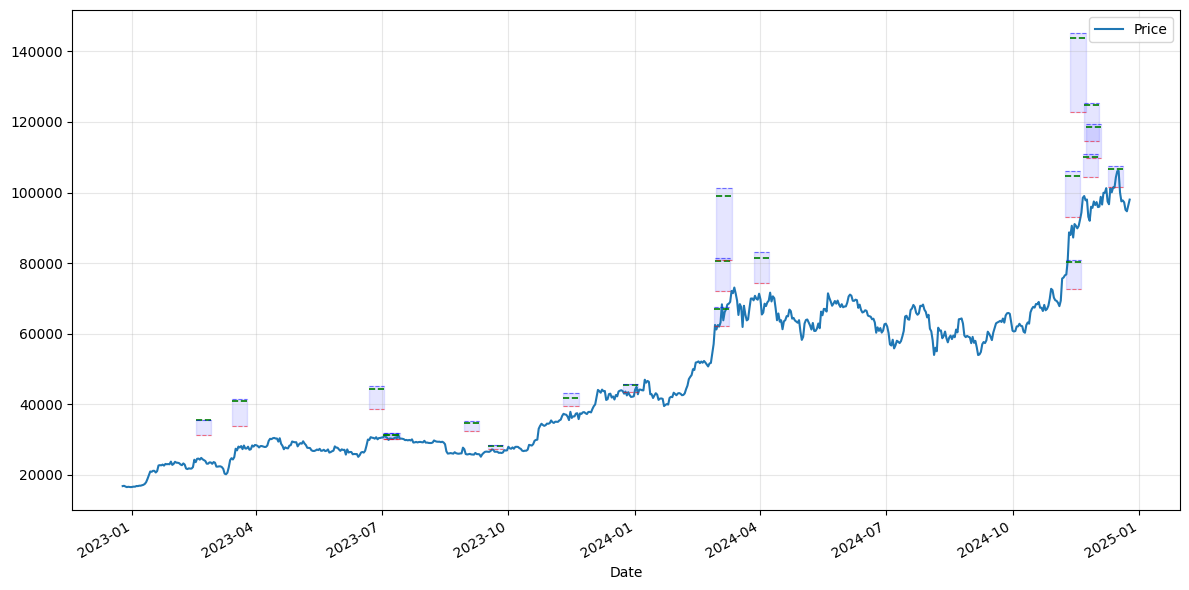

In [22]:
# Example usage:
SYMBOL = "BTC-USD"
TIMEFRAME = "1d"
START = "2y" # reduced start time

LAST_N_BARS = 3
PRED_N_BARS = 12

data = yf.download(SYMBOL, period=START, interval=TIMEFRAME)
data.sort_index(inplace=True)

pattern_ranges = find_patterns(data)
plot_projections(data, pattern_ranges)